In [1]:
import xarray as xr

data_path = "data/1month_anomaly_Global_ea_2t_201907_1991-2020_v02.grib"
original_data = xr.open_dataset(data_path, engine="cfgrib")

original_data

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] ...
Data variables:
    t2m         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-06-29T09:46 GRIB to CDM+CF via cfgrib-0.9.1...

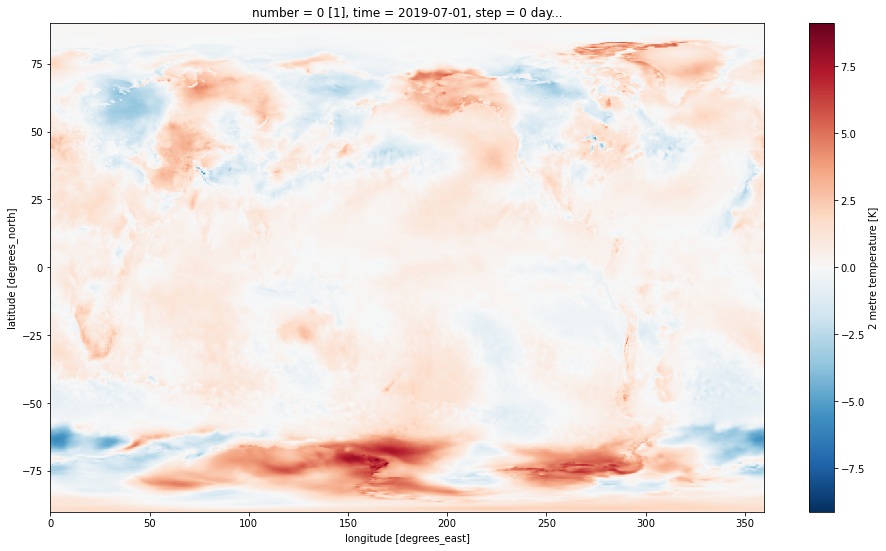

In [2]:
original_data["t2m"].plot(figsize=(16,9))

/Users/lubek/Documents/anaconda/anaconda3/envs/weather_maps/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


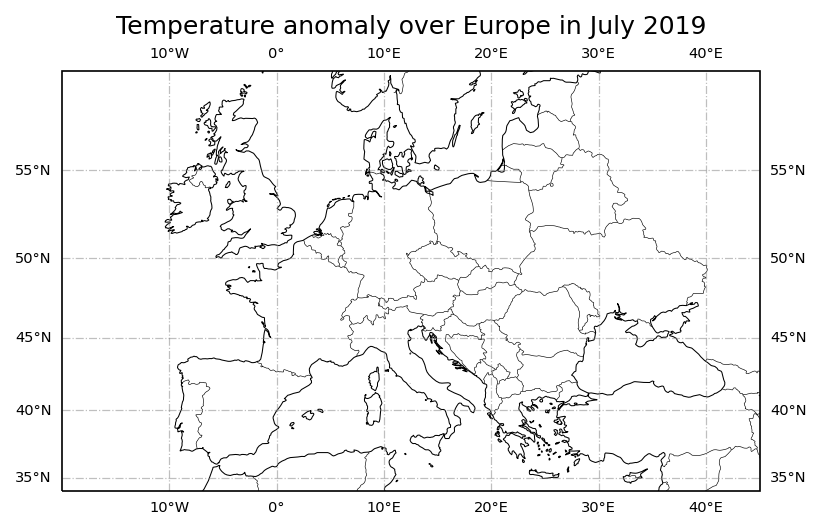

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# First we specify Coordinate Refference System for Map Projection
# We will use Mercator, which is a cylindrical, conformal projection. 
# It has bery large distortion at high latitudes, cannot 
# fully reach the polar regions.
projection = ccrs.Mercator()

# Specify CRS, that will be used to tell the code, where should our data be plotted
crs = ccrs.PlateCarree()

# Now we will create axes object having specific projection 
plt.figure(dpi=150)
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}

# To plot borders and coastlines, we can use cartopy feature
import cartopy.feature as cf
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

# Now, we will specify extent of our map in minimum/maximum longitude/latitude
# Note that these values are specified in degrees of longitude and degrees of latitude
# However, we can specify them in any crs that we want, but we need to provide appropriate
# crs argument in ax.set_extent
lon_min = -20
lon_max = 45
lat_min = 34
lat_max = 60

# crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
plt.title(f"Temperature anomaly over Europe in {original_data.valid_time.dt.strftime('%B %Y').values}")
plt.show()

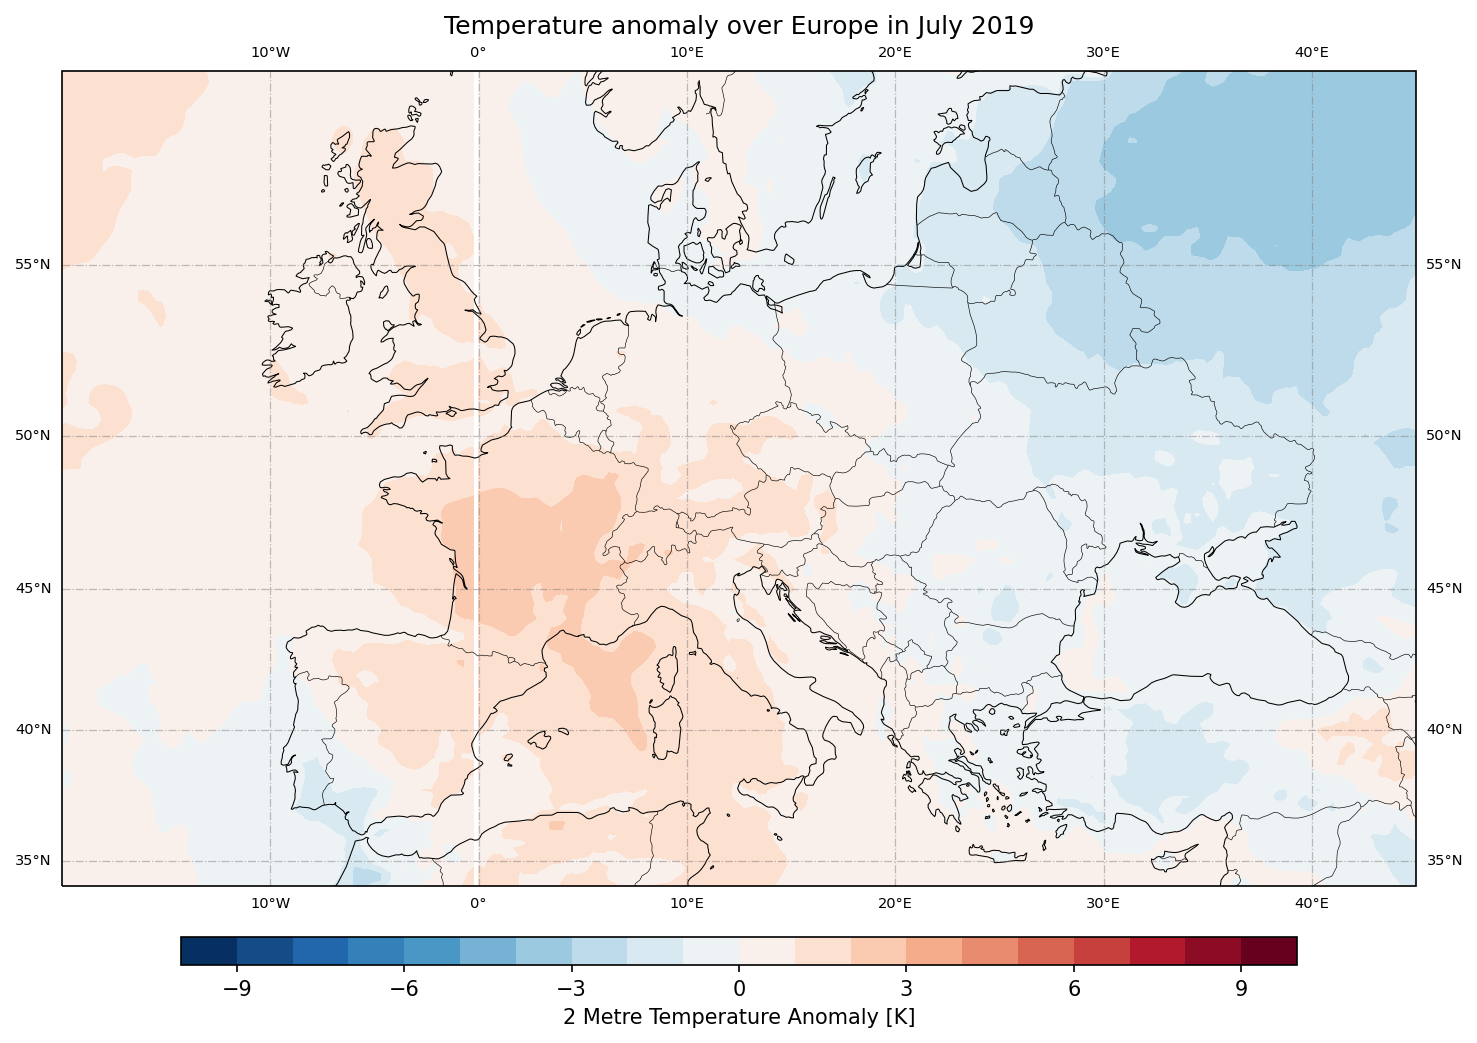

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

def plot_dataset(dataset : xr.Dataset):
    # First we specify Coordinate Refference System for Map Projection
    # We will use Mercator, which is a cylindrical, conformal projection. 
    # It has bery large distortion at high latitudes, cannot 
    # fully reach the polar regions.
    projection = ccrs.Mercator()
    # Specify CRS, that will be used to tell the code, where should our data be plotted
    crs = ccrs.PlateCarree()
    # Now we will create axes object having specific projection 
    plt.figure(figsize=(16,9), dpi=150)
    ax = plt.axes(projection=projection, frameon=True)
    # Draw gridlines in degrees over Mercator map
    gl = ax.gridlines(crs=crs, draw_labels=True,
                    linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
    gl.xlabel_style = {"size" : 7}
    gl.ylabel_style = {"size" : 7}
    # To plot borders and coastlines, we can use cartopy feature
    import cartopy.feature as cf
    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
    
    # Now, we will specify extent of our map in minimum/maximum longitude/latitude
    # Note that these values are specified in degrees of longitude and degrees of latitude
    # However, we can specify them in any crs that we want, but we need to provide appropriate
    # crs argument in ax.set_extent
    lon_min = -20
    lon_max = 45
    lat_min = 34
    lat_max = 60
    # crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
    ##### WE ADDED THESE LINES #####
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}
    dataset["t2m"].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, levels=21)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    
    plt.title(f"Temperature anomaly over Europe in {dataset.valid_time.dt.strftime('%B %Y').values}")
    plt.show()

plot_dataset(original_data)

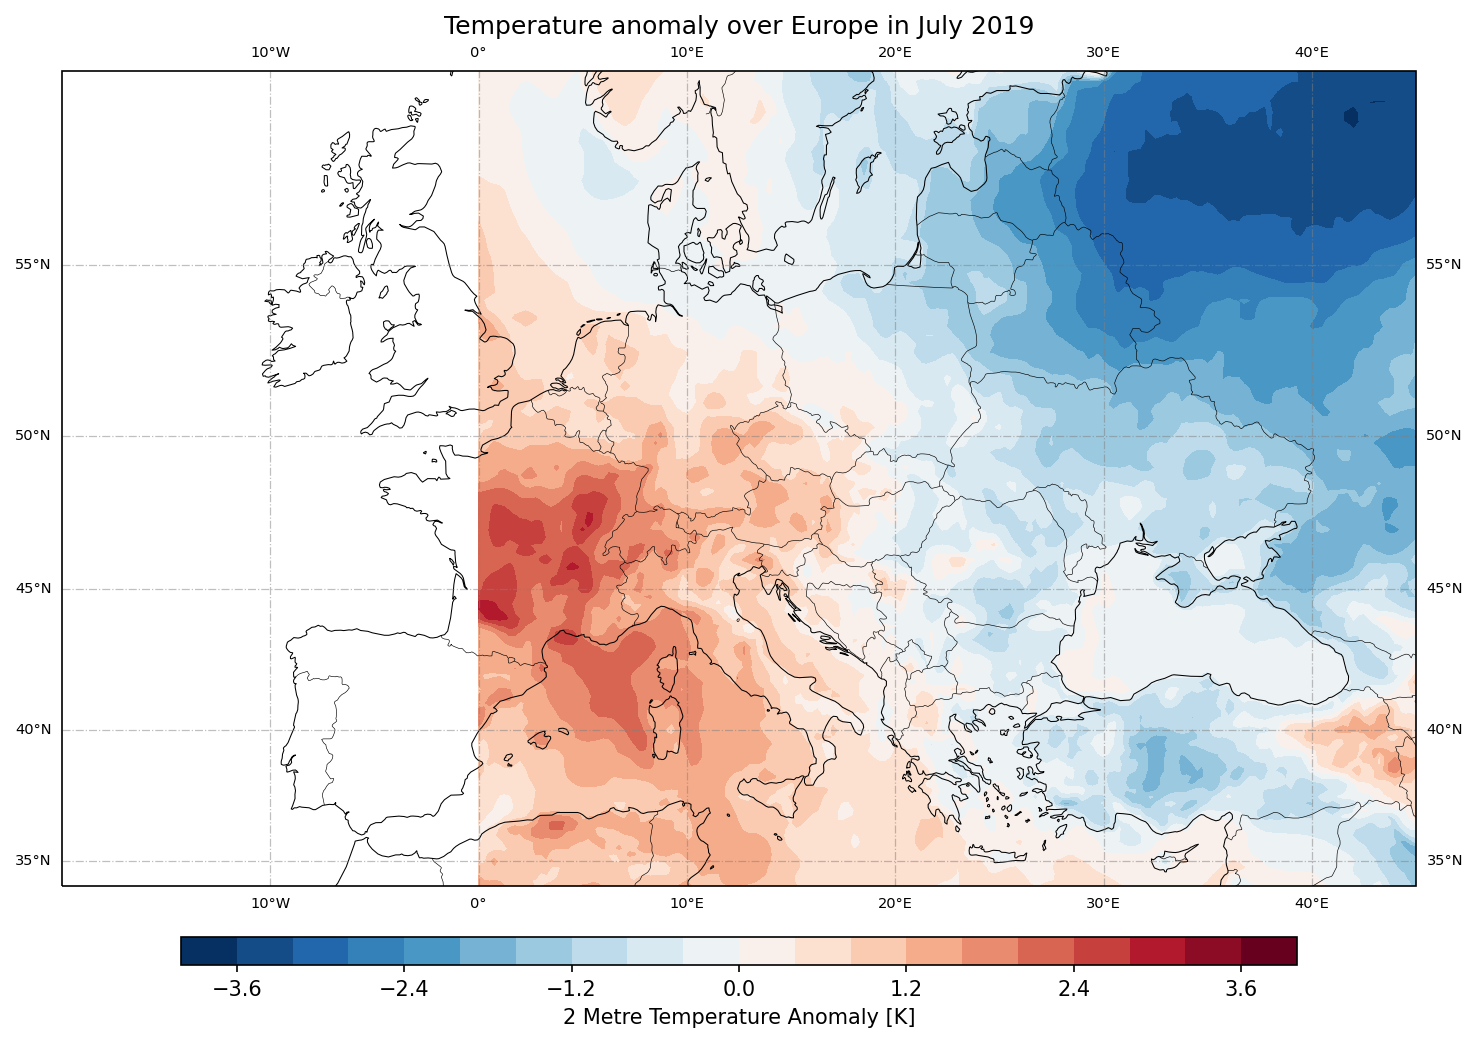

In [5]:
from copy import deepcopy
# Create copy of the data so we maintain original data
cropped_dataset = deepcopy(original_data) 
cropped_dataset = cropped_dataset.sel(
        latitude=slice(lat_max, lat_min), 
        longitude=slice(lon_min, lon_max)
    )
plot_dataset(cropped_dataset)

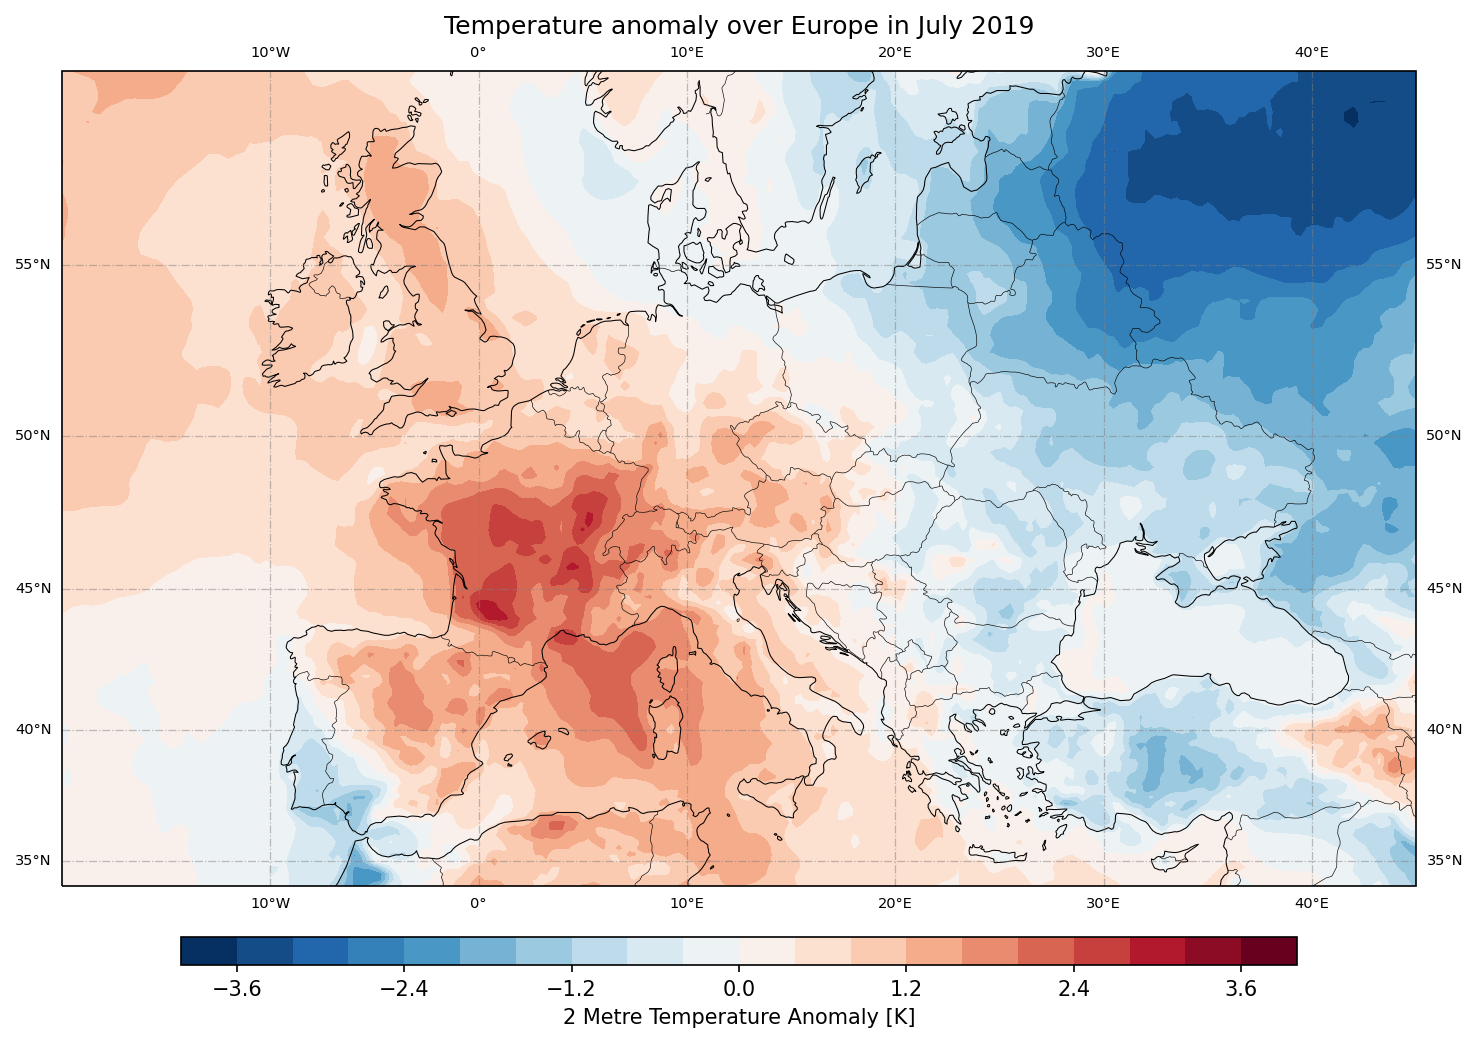

In [7]:
from copy import deepcopy
from cartopy.util import add_cyclic_point

# Create copy of the data so we maintain original data
cropped_dataset = deepcopy(original_data) 

def adjust_longitude(dataset: xr.Dataset) -> xr.Dataset:
        """Swaps longitude coordinates from range (0, 360) to (-180, 180)

        Args:
            dataset (xr.Dataset): xarray Dataset

        Returns:
            xr.Dataset: xarray Dataset with swapped longitude dimensions
        """
        lon_name = "longitude"  # whatever name is in the data

        # Adjust lon values to make sure they are within (-180, 180)
        dataset["_longitude_adjusted"] = xr.where(
            dataset[lon_name] > 180, dataset[lon_name] - 360, dataset[lon_name]
        )
        dataset = (
            dataset.swap_dims({lon_name: "_longitude_adjusted"})
            .sel(**{"_longitude_adjusted": sorted(dataset._longitude_adjusted)})
            .drop(lon_name)
        )

        dataset = dataset.rename({"_longitude_adjusted": lon_name})
        return dataset

cropped_dataset = adjust_longitude(cropped_dataset)

cropped_dataset = cropped_dataset.sel(
        latitude=slice(lat_max, lat_min), 
        longitude=slice(lon_min, lon_max)
    )

plot_dataset(cropped_dataset)